In [1]:
using FurutaRL
using ReinforcementLearning
using Flux
using Random
using Plots
using StableRNGs
using IntervalSets
using CUDA
using Statistics
using BSON: @save, @load
using BSON
using Logging
using TensorBoardLogger: TBLogger
using CircularArrayBuffers
using Dates
using Distributions
CUDA.allowscalar(false)

In [2]:
function pgd(agent::DemoAgent, x0; ϵ = 0.1, steps = 10)
    A = agent.policy.behavior_actor.model
    C = agent.policy.target_critic.model

    s0 = [sin(x0[1]), cos(x0[1]), x0[2:end]...]
    s0 = send_to_device(device(A), s0)
    a = A(s0)
    
    x = copy(x0)
    α = 2.5*ϵ/steps
    for k in 1:steps
        grad = gradient(Flux.params(x)) do
            s = [sin(x[1]), cos(x[1]), x[2:end]...]
            s = send_to_device(device(A), s)
            mean(C(vcat(s0, A(s))))
        end
        x = x - α*sign.(grad[x])
        x = clamp.(x, x0.-ϵ, x0.+ϵ)
    end
    cpu(x)
end

pgd (generic function with 1 method)

In [3]:
function test(agent, env)
    reset!(env)
    t, done = 0, false
    X = []
    U = []
    c_reward = 0
    @time while !done && t <= 833
        push!(X, copy(env.env.state))
        s = state(env) + rand(Normal(0, 0.1), 5)
        a = action(agent, s; training=false)
        push!(U, a)
        env(a)
        t += 1
        c_reward += reward(env)
        #done = is_terminated(env)
    end
    θ = [rem2pi(x[1], RoundNearest) for x in X]
    #θ = [x[1] for x in X]
    θ̇ = [x[2] for x in X]
    ϕ = [x[3] for x in X]
    ϕ̇ = [x[4] for x in X]
    tt = range(0, stop=Tf, step = Ts)
    display("Reward: $c_reward")
    display(plot(θ, title="θ"))
    #display(plot(θ̇ , title="dθ̇ "))
    display(plot(ϕ, title="ϕ"))
    #display(plot(ϕ̇ , title="dϕ̇ "))
    display(plot(U, title="u"))
end

test (generic function with 1 method)

In [4]:
function Initialize(agent::DemoAgent, env::AbstractEnv)
    t = 0
    t_max = agent.policy.start_steps
    for e in 1:1000
        #t < 3000 ? reset!(env) : reset!(env.env, [(rand(rng, T) - 1)*2*π, (rand(rng, T) - 1)*2, 0, 0])
        reset!(env.env, [rand(rng, T)*2*π, (rand(rng, T)*4 - 2), 0, 0])
        #reset!(env.env, [(rand(rng, T)*π + π/2), (rand(rng, T)*2 - 1), 0, 0])
        #reset!(env)
    
        while !is_terminated(env)
            t += 1
            s = state(env)
            a = action(agent, s)
        
            s´, r, done, _ = env(a)
        
            experience = (state=s, action=a, reward=r, terminal=done, next_state=s´)
        
            record!(agent.trajectory, experience)
            record!(agent.demo_trajectory, experience)
            
            if t >= t_max
                break
            end
        end
        
        if t >= t_max
            break
        end
    end
    println("DEMO INITIALIZATION FINISHED")
    sleep(3)
end

function PreTrain(agent::AbstractPolicy, env::AbstractEnv)
    actor_losses = []
    critic_losses = []
    for t in 1:35000
        agent(PRETRAIN_STAGE, env)
        
        push!(actor_losses, agent.policy.actor_loss)
        if agent.policy.critic_loss < 1e12
            push!(critic_losses, agent.policy.critic_loss)
        elseif length(critic_losses) == 0
            push!(critic_losses, 0)
        else
            push!(critic_losses, critic_losses[end])
        end
        
        IJulia.clear_output(true)
        p1 = plot(actor_losses, 
            title="Actor Loss", 
            xlabel = "Batch", 
            ylabel = "Loss",
            legend=false)
        p2 = plot(critic_losses, 
            title="Critic Loss", 
            xlabel = "Batch", 
            ylabel = "Loss",
            legend=false)#, ylims=(-Inf,600))
        plot(p1, p2, layout = (2, 1), size=(600, 600)) |> display
    end
    
    println("PRETRAINING FINISHED")
    sleep(5)
end;

In [5]:
t = Dates.format(now(), "yyyy_mm_dd_HH_MM_SS")
save_dir = joinpath("C:\\Users\\Philip\\OneDrive", "checkpoints", "JuliaRL_DDPG_Furuta_$t")

T = Float32
Ts = T(0.006)
Tf = 5
lg = TBLogger(joinpath(save_dir, "tb_log"), min_level = Logging.Info)
rng = StableRNG(0)
inner_env = FurutaEnv(dt = Ts, max_torque=T(0.04), max_steps = ceil(Int, Tf/Ts), T = T, rng = rng)
A = action_space(inner_env)
low = A.left
high = A.right
ns = length(state(inner_env))

env = ActionTransformedEnv(
    inner_env;
    action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
)
init = glorot_uniform(rng)

# create_actor() = Chain(
#     Dense(ns, 300, relu; initW = init),
#     Dense(300, 400, relu; initW = init),
#     Dense(400, 300, relu; initW = init),
#     Dense(300, 1, tanh; initW = init),
# ) |> gpu

# create_critic() = Chain(
#     Dense(ns + 1, 300, relu; initW = init),
#     Dense(300, 400, relu; initW = init),
#     Dense(400, 300, relu; initW = init),
#     Dense(300, 1; initW = init),
# ) |> gpu
create_actor() = Chain(
    Dense(ns, 24, relu; initW = init),
    Dense(24, 48, relu; initW = init),
    Dense(48, 72, relu; initW = init),
    Dense(72, 96, relu; initW = init),
    Dense(96, 128, relu; initW = init),
    Dense(128, 1, tanh; initW = init),
) |> gpu

create_critic() = Chain(
    Dense(ns + 1, 24, relu; initW = init),
    Dense(24, 48, relu; initW = init),
    Dense(48, 72, relu; initW = init),
    Dense(72, 96, relu; initW = init),
    Dense(96, 128, relu; initW = init),
    Dense(128, 1; initW = init),
) |> gpu
# create_actor() = Chain(
#     Dense(ns, 24, relu; initW = init),
#     Dense(24, 48, relu; initW = init),
#     Dense(48, 72, relu; initW = init),
#     Dense(72, 1, tanh; initW = init),
# ) |> gpu

# create_critic() = Chain(
#     Dense(ns + 1, 24, relu; initW = init),
#     Dense(24, 48, relu; initW = init),
#     Dense(48, 72, relu; initW = init),
#     Dense(72, 1; initW = init),
# ) |> gpu

agent = DemoAgent(
    policy = DDPGPolicyDemo(
        behavior_actor = NeuralNetworkApproximator(
            model = create_actor(),
            optimizer = Flux.Optimise.Optimiser(ClipNorm(1), ADAM(1e-4)),
        ),
        behavior_critic = NeuralNetworkApproximator(
            model = create_critic(),
            optimizer = Flux.Optimise.Optimiser(ClipNorm(1), ADAM()),
        ),
        target_actor = NeuralNetworkApproximator(
            model = create_actor(),
            optimizer = Flux.Optimise.Optimiser(ClipNorm(1), ADAM(1e-4)),
        ),
        target_critic = NeuralNetworkApproximator(
            model = create_critic(),
            optimizer = Flux.Optimise.Optimiser(ClipNorm(1), ADAM()),
        ),
        γ = 0.99f0,
        ρ = 0.995f0,
        batch_size = 256,
        start_steps = 50000,
        start_policy = FurutaPolicy(A),
        update_after = 50000,
        update_every = 1,
        act_limit = 1.0,
        act_noise = 0.1,
        rng = rng,
    ),
    trajectory = CircularArraySARTSTrajectory(
        capacity = 100000,
        state = Vector{Float32} => (ns,),
        action = Float32 => (),
        next_state = Vector{Float32} => (ns,),
    ),
    demo_trajectory = CircularArraySARTSTrajectory(
        capacity = 50000,
        state = Vector{Float32} => (ns,),
        action = Float32 => (),
        next_state = Vector{Float32} => (ns,),
    )
);


In [35]:
Initialize(agent, env)
#PreTrain(agent, env)

DEMO INITIALIZATION FINISHED


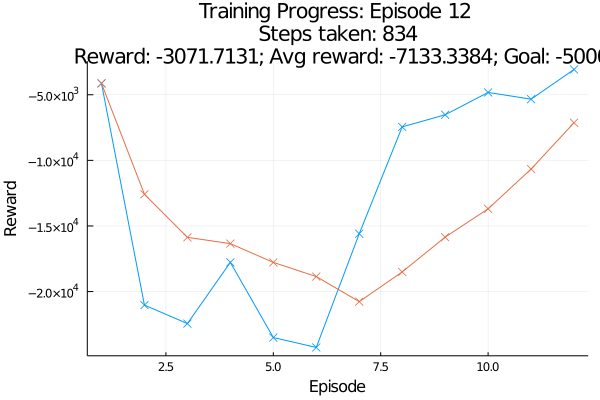

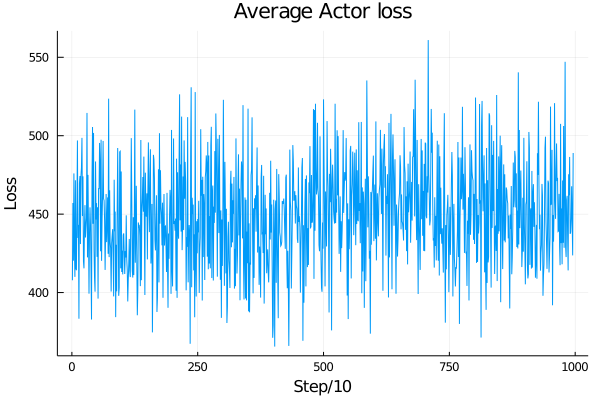

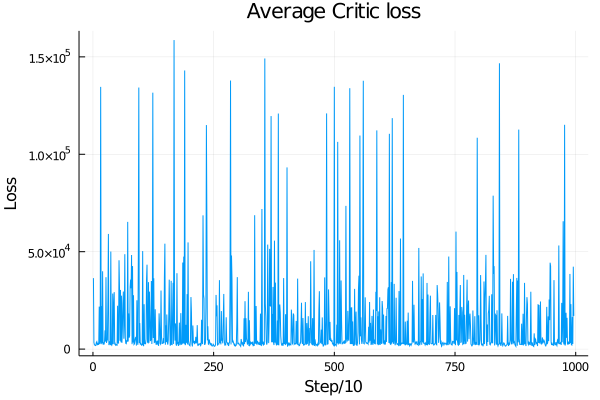

"Reward: -8819.231"

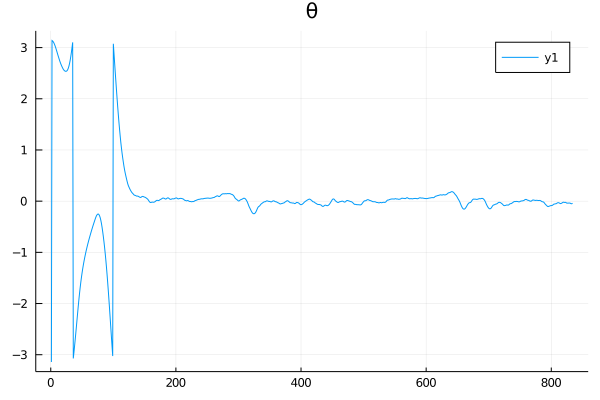

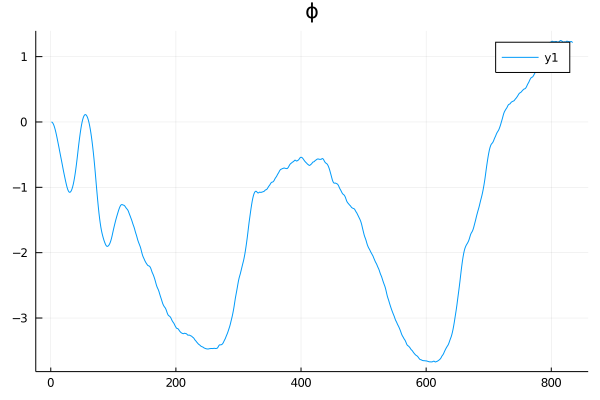

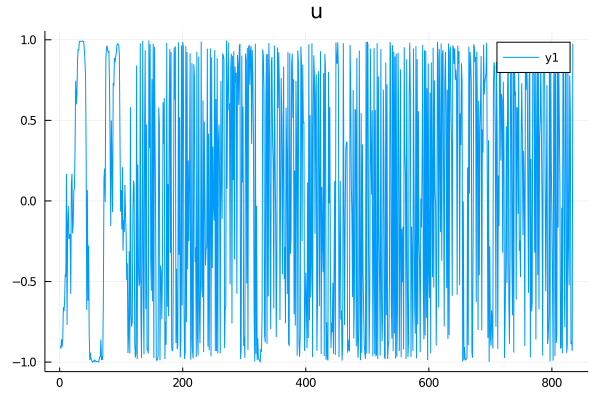

  0.298460 seconds (332.79 k allocations: 10.757 MiB)
Training stopped: average reward is -7133.3384
331.182819 seconds (348.85 M allocations: 13.102 GiB, 0.92% gc time)


In [39]:
ep_reward_list = []
avg_reward_list = []
actor_loss_list = []
critic_loss_list = []

@time for e in 1:10000
    #reset!(env.env, [(rand(rng, T)*2*π), (rand(rng, T)*4 - 2), 0, 0])
    reset!(env.env, [(rand(rng, T)*π + π/2), (rand(rng, T)*2 - 1), 0, 0])
    #reset!(env.env, [(rand(rng, T)*2*π), (rand(rng, T)*10-5), rand(rng, T)*4*π-2*π, rand(rng, T)*10-5])
    #reset!(env)
    t, c_reward, c_act_loss, c_crit_loss, done = 0, 0, 0, 0, false
    
    X = []
    
    while !is_terminated(env)
        s0 = env.env.state
        push!(X, s0)
        
        #s0 = pgd(agent, s0, ϵ=0.005, steps=10)
        s = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
        #s += rand(Normal(0, 0.2), 5)
        a = action(agent, s)
        #a = rand(rng, T)*0.08-0.04

        s´, r, done, _ = env(a)
        experience = (state=s, action=a, reward=r, terminal=done, next_state=s´)
        
        record!(agent.trajectory, experience)
        update!(agent)
        #update_critic!(agent.policy, agent.trajectory, agent.demo_trajectory)
        
        c_reward += reward(env)
        c_act_loss += agent.policy.actor_loss
        c_crit_loss += agent.policy.critic_loss
        t += 1
        
        if t % 10 == 0
            push!(actor_loss_list, c_act_loss/10)
            c_act_loss = 0
            push!(critic_loss_list, c_crit_loss/10)
            c_crit_loss = 0
        end
    end
    push!(X, env.env.state)
    
    push!(ep_reward_list, c_reward)
    avg_reward = mean(ep_reward_list[max(1,end-5):end])
    push!(avg_reward_list, avg_reward)
    
    IJulia.clear_output(true)
    goal = ep_reward_list[1]
    p1 = plot(ep_reward_list, 
        title="Training Progress: Episode $e \n Steps taken: $t \n Reward: $c_reward; Avg reward: $avg_reward", 
        xlabel = "Episode", 
        ylabel = "Reward", label="Episode reward",
        marker = :x, legend=false)
    p1 = plot!(avg_reward_list, label = "Average reward", marker = :x)
    display(p1)
#     θ = [rem2pi(x[1], RoundNearest) for x in X]
#     ϕ = [x[3] for x in X]
#     display(plot(θ, title="θ", legend=false))
#     display(plot(ϕ, title="ϕ", legend=false))
    p2 = plot(actor_loss_list, title="Average Actor loss", xlabel="Step/10", ylabel="Loss", legend=false)
    p3 = plot(critic_loss_list, title="Average Critic loss", xlabel="Step/10", ylabel="Loss", legend=false)
    display(p2)
    display(p3)
    test(agent, env)
    
        
#     if c_reward > -4500 && t >= 833
#         name = "Agent$e.bson"
#         model = cpu(agent)
#         @save name model
#     end
    
     if avg_reward > -10000 && e > 10# && t >= 833
         println("Training stopped: average reward is $avg_reward")
         break
     end
#     if e == 100
#         break
#     end
end

"Reward: -14175.938"

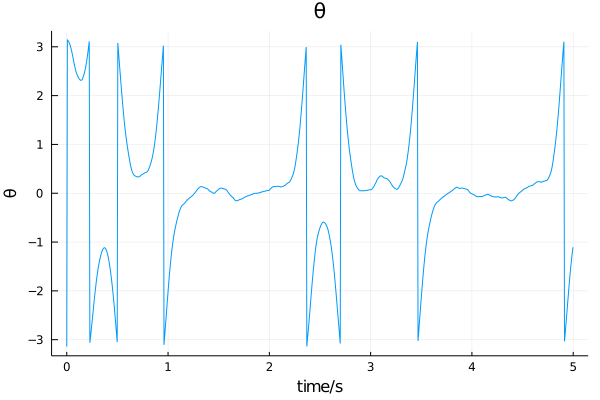

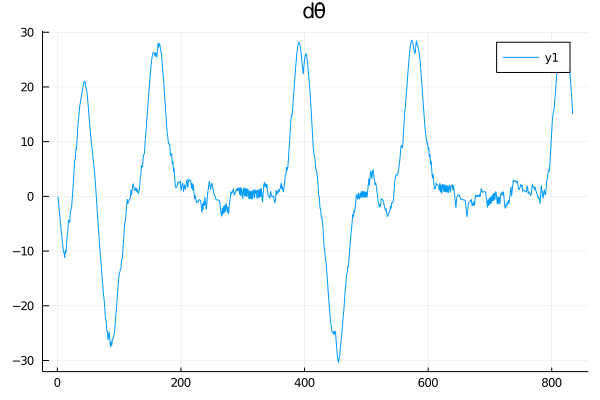

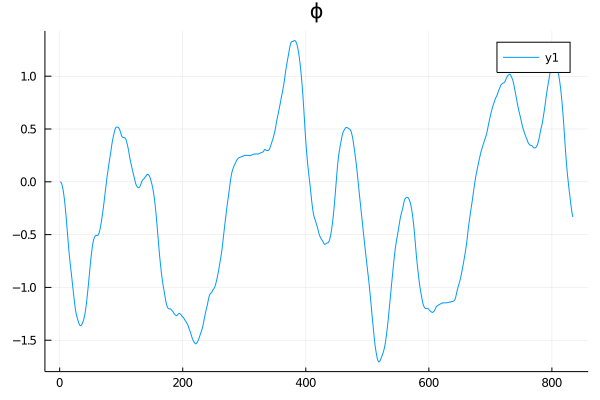

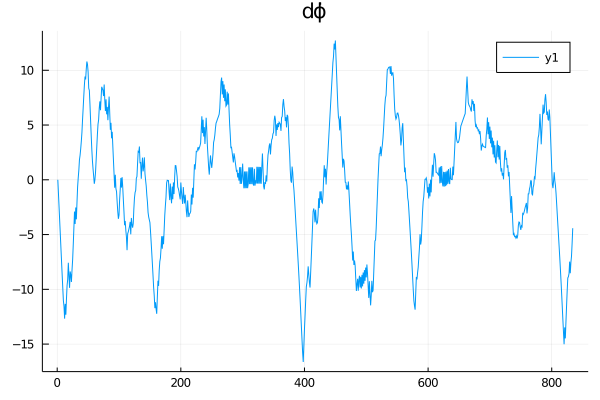

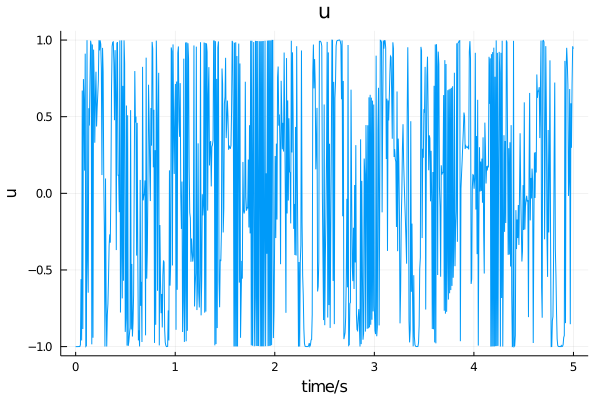

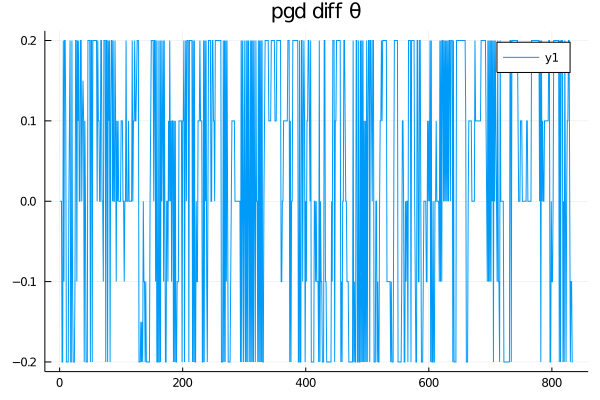

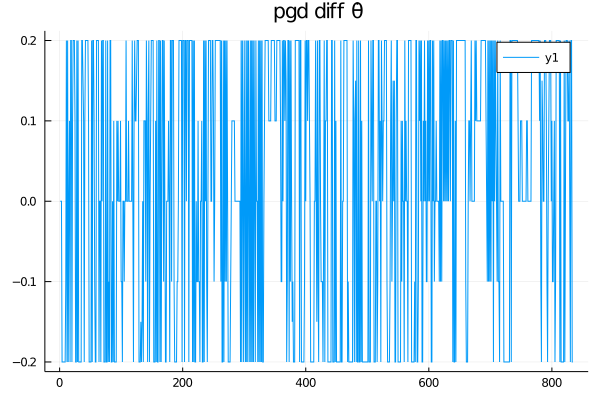

 12.792072 seconds (36.54 M allocations: 1.253 GiB, 2.65% gc time)


In [131]:
policy = FurutaPolicy()
reset!(env.env, [π, 0, 0, 0])
#reset!(env.env, [(rand(rng, T)*2*π), (rand(rng, T)*5-2.5), 0, 0])
#reset!(env.env, [(rand(rng, T)*2*π), (rand(rng, T)*10-5), rand(rng, T)*4*π-2*π, rand(rng, T)*10-5])
#reset!(env.env, [(rand(rng, T)*π + π/2), (rand(rng, T)*2 - 1), 0, 0])
t, done = 0, false
ts = [];
X = []
U = []
X_pgd = []
c_reward = 0
@time while !done && t <= 833
    push!(ts, t*0.006)
    push!(X, copy(env.env.state))
    #a = policy(env)
    x = copy(env.env.state)
    #x = x + rand(Normal(0, 0.2), 4)
    x = pgd(agent, x, ϵ=0.2, steps=10)
    s = [sin(x[1]), cos(x[1]), x[2:end]...]
    a = action(agent, s; training=false)
    #a = action(policy, s)
    #a = 0
    #a = f(env, agent)
    push!(U, a)
    push!(X_pgd, x)
    env(a)
    t += 1
    c_reward += reward(env)
    #done = is_terminated(env)
end
θ = [rem2pi(x[1], RoundNearest) for x in X]
#θ = [x[1] for x in X]
θ̇ = [x[2] for x in X]
ϕ = [x[3] for x in X]
ϕ̇ = [x[4] for x in X]
θ_pgd = [rem2pi(x[1], RoundNearest) for x in X_pgd]
θ̇_pgd = [x[2] for x in X_pgd]
tt = range(0, stop=Tf, step = Ts)
display("Reward: $c_reward")
pθ = plot(ts, θ, title="θ", ylabel="θ", xlabel="time/s", label=nothing)
display(pθ)
display(plot(θ̇ , title="dθ̇ "))
display(plot(ϕ, title="ϕ"))
display(plot(ϕ̇ , title="dϕ̇ "))
pu = plot(ts, U, title="u", ylabel="u", xlabel="time/s", label=nothing)
display(pu)
display(plot(rem2pi.(θ.-θ_pgd, RoundNearest), title="pgd diff θ"))
display(plot(θ̇.-θ̇_pgd, title="pgd diff θ̇"))

In [132]:
savefig(pθ, "figures/e0150_e02_theta.svg")
savefig(pu, "figures/e0150_e02_u.svg")

In [310]:
using LinearAlgebra
function f(env, agent)
    x = env.env.state
    if abs(rem2pi(x[1], RoundNearest)) < 0.3 && abs(x[2]) < 3
        L = [-2.3312, -0.1552, -0.0688, -0.0782]
        u = dot(-L,x)/env.env.params.max_torque
    else
        u = agent.policy(env, training=false)
    end
    clamp(u, -1.0, 1.0)
end

f (generic function with 1 method)

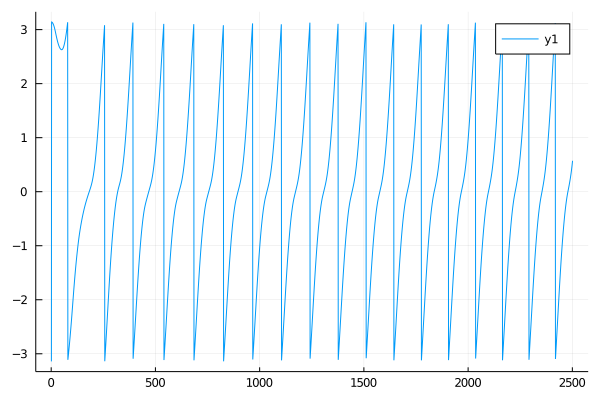

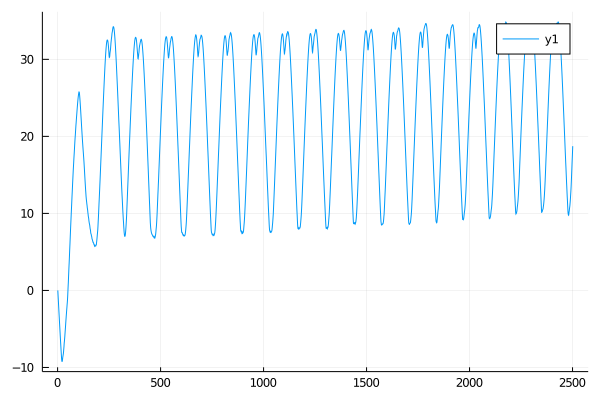

In [44]:
reset!(env)
t, done = 0, false
X = []
while !done && t <= 2500
    push!(X, copy(env.env.state))
    action = agent(env)
    env(action)
    t += 1
end
θ = [rem2pi(x[1], RoundNearest) for x in X]
θ̇ = [x[2] for x in X]
tt = range(0, stop=Tf, step = Ts)
display(plot(θ))
display(plot(θ̇ ))

In [212]:
function evaluate(θ)
    t_start = ceil(Int, len(θ)/2)
    failed = false
    for k = t_start:len(θ)
        if abs(θ[k]) > π/2
            failed = true
            break
        end
    end
    failed
end 

Float32[3.1415927, 0.0, 0.0, 0.0]
Float32[3.1415927, -4.1740456f-8, -1.922484f-12, -1.922331f-9]


In [ ]:
p1 = plot(range(0,stop=10, length=20), title="Lines", label = "line 1", marker=:x)
display(p1)
p1 = plot!(range(10,stop=0, length=20), label = "line 2")
display(p1)

In [130]:
@load "stat_agents_4/01500pgd03.bson" model
agent = gpu(model)

DemoAgent
├─ policy => DDPGPolicyDemo
│  ├─ behavior_actor => NeuralNetworkApproximator
│  │  ├─ model => Chain
│  │  │  └─ layers
│  │  │     ├─ 1
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 24×5 CuArray{Float32,2}
│  │  │     │     ├─ b => 24-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 2
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 48×24 CuArray{Float32,2}
│  │  │     │     ├─ b => 48-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 3
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 72×48 CuArray{Float32,2}
│  │  │     │     ├─ b => 72-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 4
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 96×72 CuArray{Float32,2}
│  │  │     │     ├─ b => 96-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 5
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 128×96 CuArray{Float32,2}
│  │  │     │     ├─ b => 128

In [126]:
@load "BASELINE4.bson" model
agent = gpu(model)

DemoAgent
├─ policy => DDPGPolicyDemo
│  ├─ behavior_actor => NeuralNetworkApproximator
│  │  ├─ model => Chain
│  │  │  └─ layers
│  │  │     ├─ 1
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 24×5 CuArray{Float32,2}
│  │  │     │     ├─ b => 24-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 2
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 48×24 CuArray{Float32,2}
│  │  │     │     ├─ b => 48-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 3
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 72×48 CuArray{Float32,2}
│  │  │     │     ├─ b => 72-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 4
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 96×72 CuArray{Float32,2}
│  │  │     │     ├─ b => 96-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 5
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 128×96 CuArray{Float32,2}
│  │  │     │     ├─ b => 128

In [40]:
model = cpu(agent)
@save "BASELINE10k.bson" model

In [15]:
model = cpu(agent.policy.behavior_actor.model)
@save "0014pgd1_model.bson" model

In [22]:
name = "stat_agents/0005pgd20"
load_name = name * ".bson"
@load load_name model
model = model.policy.behavior_actor.model
save_name = name * "_model.bson"
@save save_name model

In [69]:
using MAT
@load "BASELINE4.bson" model
model = model.policy.behavior_critic.model
W1 = Flux.params(model)[1]
W2 = Flux.params(model)[3]
W3 = Flux.params(model)[5]
W4 = Flux.params(model)[7]
W5 = Flux.params(model)[9]
W6 = Flux.params(model)[11]
matwrite("Matlab_export_model.mat", Dict(
        "W1" => W1, "W2" => W2, "W3" => W3, "W4" => W4, "W5" => W5, "W6" => W6))

In [34]:
agent = DemoAgent(
    policy = agent.policy,
    trajectory = CircularArraySARTSTrajectory(
        capacity = 100000,
        state = Vector{Float32} => (ns,),
        action = Float32 => (),
        next_state = Vector{Float32} => (ns,),
    ),
    demo_trajectory = CircularArraySARTSTrajectory(
        capacity = 50000,
        state = Vector{Float32} => (ns,),
        action = Float32 => (),
        next_state = Vector{Float32} => (ns,),
    )
)
agent.policy.step = 0
# agent.policy.update_after = 1000
# agent.policy.start_steps = 1000

0

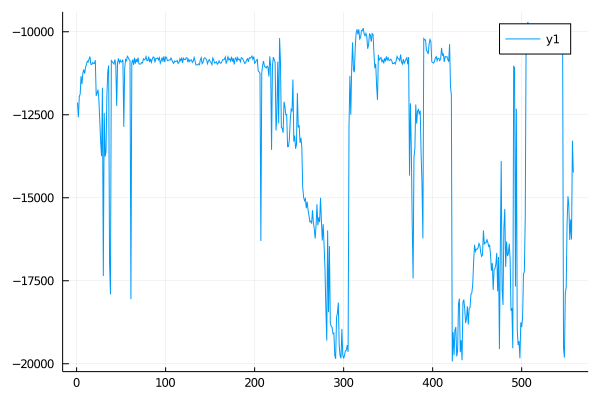

In [45]:
display(plot(ep_reward_list[isless.(-20000,ep_reward_list)]))

In [51]:
agent

DemoAgent
├─ policy => DDPGPolicyDemo
│  ├─ behavior_actor => NeuralNetworkApproximator
│  │  ├─ model => Chain
│  │  │  └─ layers
│  │  │     ├─ 1
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 24×5 CuArray{Float32,2}
│  │  │     │     ├─ b => 24-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 2
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 48×24 CuArray{Float32,2}
│  │  │     │     ├─ b => 48-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 3
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 72×48 CuArray{Float32,2}
│  │  │     │     ├─ b => 72-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 4
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 96×72 CuArray{Float32,2}
│  │  │     │     ├─ b => 96-element CuArray{Float32,1}
│  │  │     │     └─ σ => typeof(relu)
│  │  │     ├─ 5
│  │  │     │  └─ Dense
│  │  │     │     ├─ W => 128×96 CuArray{Float32,2}
│  │  │     │     ├─ b => 128

In [38]:
c_agent = cpu(agent)
W1 = Flux.params(c_agent.policy.behavior_actor.model)[1]
W2 = Flux.params(c_agent.policy.behavior_actor.model)[3]
W3 = Flux.params(c_agent.policy.behavior_actor.model)[5]
W4 = Flux.params(c_agent.policy.behavior_actor.model)[7]
W5 = Flux.params(c_agent.policy.behavior_actor.model)[9]
W6 = Flux.params(c_agent.policy.behavior_actor.model)[11]

b1 = Flux.params(c_agent.policy.behavior_actor.model)[2]
b2 = Flux.params(c_agent.policy.behavior_actor.model)[4]
b3 = Flux.params(c_agent.policy.behavior_actor.model)[6]
b4 = Flux.params(c_agent.policy.behavior_actor.model)[8]
b5 = Flux.params(c_agent.policy.behavior_actor.model)[10]
b6 = Flux.params(c_agent.policy.behavior_actor.model)[12]

Ws = [W1, W2, W3, W4, W5, W6]
N = [size(w)[1] for w in Ws]
M = [size(w)[2] for w in Ws]
println(N)
println(M)

A = BlockArray(zeros(sum(N)-1, sum(M)), N[1:end-1], M)
setblock!(A, W1, 1,1)
setblock!(A, W2, 2,2)
setblock!(A, W3, 3,3)
setblock!(A, W4, 4,4)
setblock!(A, W5, 5,5)
A = sparse(A)

B = BlockArray(zeros(sum(N)-1, sum(M)), N[1:end-1], M)
setblock!(B, Matrix(I, N[1], N[1]), 1,2)
setblock!(B, Matrix(I, N[2], N[2]), 2,3)
setblock!(B, Matrix(I, N[3], N[3]), 3,4)
setblock!(B, Matrix(I, N[4], N[4]), 4,5)
setblock!(B, Matrix(I, N[5], N[5]), 5,6)
B = sparse(B);

[24, 48, 72, 96, 128, 1]
[5, 24, 48, 72, 96, 128]


LoadError: UndefVarError: BlockArray not defined

In [6]:
α = 0.0
β = 1.0
n = sum(N[1:end-1])
m = sum(M)

M_matrix = -Matrix(I, M[1], M[1])
M_matrix = [M_matrix zeros(M[1], sum(M[2:end]));
    zeros(sum(M[2:end-1]), sum(M));
    zeros(M[end], sum(M[1:end-1])) W6'*W6]

#M_expr = [A; B]'*[zeros(n,n) diagm(vec(ones(n,1))); diagm(vec(ones(n,1))) -2*diagm(vec(ones(n,1)))]*[A; B] + M_matrix
M_expr = M_matrix + B'*diagm(vec(ones(n,1)))*A + A'*diagm(vec(ones(n,1)))*B - 2*B'*diagm(vec(ones(n,1)))*B
idxs = findall(x->x < 1e-10, M_expr)

#opt_model = Model(() -> COSMO.Optimizer(max_iter=50000))
opt_model = Model(Mosek.Optimizer)
@variable(opt_model, λ[1:n] >= 0)
@variable(opt_model, ρ)
@variable(opt_model, X[1:m, 1:m], PSD)

M_matrix = -ρ*Matrix(I, M[1], M[1])
M_matrix = [M_matrix zeros(M[1], sum(M[2:end]));
    zeros(sum(M[2:end-1]), sum(M));
    zeros(M[end], sum(M[1:end-1])) W6'*W6]

#M_expr = [A; B]'*[zeros(n,n) diagm(λ); diagm(λ) -2*diagm(λ)]*[A; B] + M_matrix
M_expr = M_matrix + B'*diagm(λ)*A + A'*diagm(λ)*B - 2*B'*diagm(λ)*B
@objective(opt_model, Min, ρ)
for i=1:m, j=1:m
    if CartesianIndex(i,j) in idxs && i >= j
        @constraint(opt_model, -M_expr[i,j] == X[i,j])
    end
end
#@SDconstraint(opt_model, -M_expr >= zeros(size(M_expr)));

In [7]:
@time optimize!(opt_model)
@show termination_status(opt_model)

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6580) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6581) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6583) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6584) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6585) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6587) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6589) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6592) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6593) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(6594) of matrix 'A'.
Warning number 705 is disabled

LoadError: Mosek.MosekError(1051, "Out of space.")

In [24]:
α = 0.0
β = 1.0
constants = []
L = 1

for k in 1:size(Ws,1)-1
    layer_model_1 = Model(Mosek.Optimizer)
    MOI.set(layer_model_1, MOI.Silent(), false)
    @variable layer_model_1 λ[1:N[k]]
    @variable layer_model_1 ρ
    T = λ |> Diagonal |> Matrix

    M_matrix = [-2*α*β*Ws[k]'*T*Ws[k]-ρ*Matrix(I,M[k],M[k]) (α+β)*Ws[k]'*T;
            (α+β)*T*Ws[k] -2*T+Ws[k+1]'*Ws[k+1]]
    @objective layer_model_1 Min ρ
    @constraint layer_model_1 -M_matrix in PSDCone()
    @time optimize!(layer_model_1)
    @show termination_status(layer_model_1)
    push!(constants, value(ρ))
    L = L*value(ρ)
end

L

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 435             
  Cones                  : 0               
  Scalar variables       : 25              
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

8.421427548994174e6

In [39]:
M_matrix = -Matrix(I, M[1], M[1])
M_matrix = [M_matrix zeros(M[1], sum(M[2:end]));
    zeros(sum(M[2:end-1]), sum(M));
    zeros(M[end], sum(M[1:end-1])) W6'*W6]

M_expr = [A; B]'*[zeros(n,n) diagm(vec(ones(n,1))); diagm(vec(ones(n,1))) -2*diagm(vec(ones(n,1)))]*[A; B] + M_matrix
idxs = findall(x->abs(x) < 1e-16, M_expr)
CartesianIndex(2,1) in idxs

true

In [36]:
critic = agent.policy.behavior_critic.model
actor = agent.policy.behavior_actor.model
x0 = [0, -1, 0, 0, 0] |> gpu
a = actor(x0)
println(a)
critic(vcat(x0, a))

Float32[NaN]


1-element CuArray{Float32,1}:
 NaN

In [204]:
function pgd0(agent::DemoAgent, x; ϵ = 0.1, steps = 10)
    
    A = agent.policy.behavior_actor.model
    C = agent.policy.behavior_critic.model
    #println(ϵ)

    s0 = [sin(x[1]), cos(x[1]), x[2:end]...]
    println(ϵ)
    s0 = send_to_device(device(A), s0)
    a = A(s0)
    
    x0 = copy(x)
    println("steps "*string(steps))
    α = 2.5*ϵ/steps
    println("α "*string(α))
    for k in 1:steps
        #println("before "*string(x))
        grad = gradient(Flux.params(x)) do
            s = [sin(x[1]), cos(x[1]), x[2:end]...]
            s = send_to_device(device(A), s)
            mean(C(vcat(s, a)))
        end
        #println("g "*string(grad[x]))
        #println("α "*string(α))
        #println("sg "*string(sign.(grad[x])))
        #println("asg "*string(α*sign.(grad[x])))
        x = x - α*sign.(grad[x])
        #println("mid "*string(x))
        x = clamp.(x, x0.-ϵ, x0.+ϵ)
        #println("after "*string(x))
    end
    cpu(x)
end

pgd0 (generic function with 2 methods)

In [205]:
function pgd1(agent::DemoAgent, x0; ϵ = 0.1, steps = 10)
    A = agent.policy.behavior_actor.model
    C = agent.policy.behavior_critic.model

    s0 = [sin(x0[1]), cos(x0[1]), x0[2:end]...]
    s0 = send_to_device(device(A), s0)
    a = A(s0)
    
    x = copy(x0)
    println("ϵ "*string(ϵ))
    println("steps "*string(steps))
    α = 2.5*ϵ/steps
    println("α "*string(α))
    for k in 1:steps
        #println("before "*string(x))
        grad = gradient(Flux.params(x)) do
            s = [sin(x[1]), cos(x[1]), x[2:end]...]
            s = send_to_device(device(A), s)
            mean(C(vcat(s, a)))
        end
        x = x - α*sign.(grad[x])
        #println("mid "*string(x))
        x = clamp.(x, x0.-ϵ, x0.+ϵ)
        #println("after "*string(x))
    end
    cpu(x)
end

pgd1 (generic function with 1 method)

In [208]:
reset!(env.env, [0.1,0.1,1,1])
s = env.env.state
println(s)
# x0 = [sin(s[1]), cos(s[1]), s[2:end]...]
# println(x0)
# s += [1, 1, 1, 1]
# println(s)
# println(x0)
s1 = pgd0(agent, s, ϵ = 0.5, steps=10)
println(s1)
#x0 = [sin(s[1]), cos(s[1]), s[2:end]...]

Float32[0.1, 0.1, 1.0, 1.0]
3.926402216e-315
steps 10
α 9.81600554e-316
[0.10000000149011612, 0.10000000149011612, 1.0, 1.0]


In [39]:
x = [1, 0, 0, 0] 
s = [sin(x[1]), cos(x[1]), x[2:end]...] |> gpu
C = agent.policy.behavior_critic
A = agent.policy.behavior_actor
C(vcat(s, A(s)))

1-element CuArray{Float32,1}:
 98.62543

In [ ]:
using DifferentialEquations
α, β, γ, δ, ψ, u = 1, 1, 1, 1, 1, 1
function f(x, p, t)
        θ, θ̇, ϕ, ϕ̇ = x
        dθ = θ̇
        dθ̇ = ψ*(β*(α+β*sin(θ)^2)*cos(θ)*sin(θ)*ϕ̇ ^2
            + 2*β*γ*(1-sin(θ)^2)*sin(θ)*ϕ̇ *θ̇  - γ^2*cos(θ)*sin(θ)*θ̇ ^2
            + δ*(α+β*sin(θ)^2)*sin(θ) - γ*cos(θ)*u)
        dϕ = ϕ̇
        dϕ̇ = ψ*(β*γ*(sin(θ)^2-1)*sin(θ)*θ*ϕ̇ ^2 - 2*β^2*cos(θ)*sin(θ)*ϕ̇ *θ̇
            + β*γ*sin(θ)*θ̇ ^2 - γ*δ*cos(θ)*sin(θ) + β*u)
        return [dθ, dθ̇ , dϕ, dϕ̇ ]
    end
    
    tspan = (0, 0.002)
    prob = ODEProblem(f, [π, 0, 0, 0], tspan)
    x = solve(prob, BS5())
println(x)
θ, θ̇, ϕ, ϕ̇ = x[end]